# Topic Modeling

The goal of this notebook is two-fold:
* identify the main topics of the corpus through LDA and clustering (unsupervised approach)
* train a text classifier based on these topics (supervised learning).

### Contents

__Preliminaries__
* a. Overview of text modeling techniques
* b. Imports

__1. LDA__

__2. Clustering__
* a. Tf-Idf for Clustering
* b. K-Means
* c. DBSCAN

__3. Topic classifier__

What's next

# Preliminaries

__a. Overview of text modeling techniques__

* [LDA](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

* Clustering. In order to build clusters we have to transform our news articles into a numerical representation that models can handle. Here we go for old good tf-idf vectors (we will test more state-of-the-art techniques in the next steps). Algorithms: K-Means and DBSCAN seem like the most relevant options to begin with.

* ?

__b. Imports__

If you don't have already done so, please download these NLTK dependancies by running the following lines:

> nltk.download('wordnet')

> nltk.download('stopwords')

In [1]:
# Classic packages

import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random 
random.seed(a=2905) # set random seed 
import pickle


# NLP packages

import gensim
from gensim import corpora

import spacy
try: 
    print("fr_core_news_sm loaded")
    nlp = spacy.load("fr_core_news_sm") # load pre-trained models for French
except:
    print("fr loaded")
    nlp=spacy.load('fr') # fr calls fr_core_news_sm 

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer # not adapted to French?
from nltk.stem.snowball import FrenchStemmer # already something 
# --> Lemmatizer would be better --> use spaCy lemmatizer

# ML with sklearn
import sklearn.cluster
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer 
from sklearn.feature_extraction.text import  TfidfVectorizer


fr_core_news_sm loaded


In [2]:
# data
news_df=pd.read_csv("./articles.csv")

# 1. Latent Dirichlet Allocation (LDA)


Main idea: Each document is represented as a distribution over topics, and each topic is represented as a distribution over words.
Here we do not set the number of topics in advance, we rather set it arbitrarily like a threshold and see if the results are relevant.

Code freely adapted from this [TDS post](https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21).



__Text cleaning for LDA__

* tokenize words (here using spacy parser for French)
* lemmatize (using NLTK WordNetLemmatizer)
* stopwords removal (using the default NLTK stopwords list for French)
* apply pipeline on titles and text bodies

In [3]:
## spacy LDA

spacy.load('fr')
from spacy.lang.fr import French
parser = French()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

# test
# we see it's basically a conversion of the words from the split sentence into lower case
# but actually there is more under the hood because of the use of a parser
tokenize("Il était une fois dans l'Ouest, une troupe de cowboys intrépides.")

['il',
 'était',
 'une',
 'fois',
 'dans',
 "l'",
 'ouest',
 ',',
 'une',
 'troupe',
 'de',
 'cowboys',
 'intrépides',
 '.']

In [4]:
# stopwords removal

#v0 : basic list
fr_stop = set(nltk.corpus.stopwords.words('french'))
#v1 : numbers
my_fr_stop=fr_stop.union({'un' ,'deux','trois','quatre','cinq','six','sept','huit','neuf','dix',
                          'onze', 'douze', 'treize','quatorze', 'quinze', 'seize', 
                          'vingt', 'trente', 'quarante', 'cinquante','soixante','cent'}, fr_stop)
#v2 : conj + det + verbs
my_fr_stop=fr_stop.union({'comme', 'ce', 'celui', 'cette', 'cet', 'celui-là', 'celui-ci', 
                          'le', 'la', 'les', 'de', 'des', 'du',
                          'mais', 'où', 'et', 'donc', 'or', 'ni', 'car', 'depuis', 'quand', 'que', 'qui', 'quoi',
                          'être', 'avoir', 'faire', 
                          'autre'})

#'mille'  'million' 'milliard' 'billion' are not added to the stopwords list because they are more discriminative

print(my_fr_stop)

{'ayons', 'serons', 'sommes', 'eus', 'ton', 'un', 'qu', 'la', 'fusse', 'auriez', 'comme', 'or', 'elle', 'te', 'celui-là', 'étaient', 'fûtes', 'avait', 'était', 'étée', 'aux', 'car', 'sur', 'et', 'fut', 'votre', 'avec', 'étants', 'celui', 'aurons', 'étiez', 'eussions', 'ce', 'ma', 'au', 'fussiez', 'est', 'aies', 'eusses', 'de', 'on', 'tu', 'fus', 'soient', 'fût', 'eue', 'aurez', 'avez', 'ne', 'son', 'fussent', 'ayantes', 'l', 'même', 'notre', 'aurait', 'suis', 'eusse', 'auraient', 'quoi', 'soyons', 'aurais', 'étions', 'eussent', 'vos', 'eussiez', 'furent', 'une', 'serions', 'les', 'ou', 'tes', 'eût', 'mais', 'moi', 'soyez', 'étante', 'cette', 'mes', 'fussions', 'ils', 'sera', 'ayante', 'avais', 'serais', 'avions', 'fûmes', 'ses', 'avaient', 'ai', 'ces', 'étais', 'sont', 'avons', 'nous', 'mon', 'aura', 't', 'donc', 'il', 'dans', 'à', 'étant', 'eûtes', 'celui-ci', 'cet', 'auront', 'aurai', 'y', 'des', 'seront', 'avoir', 'lui', 'me', 'eux', 'étantes', 'ta', 'depuis', 'en', 'étés', 'pas', '

In [5]:
# Comparison: nltk french stemmer vs spacy french lemmatizer

# spacy
print("\nLemmas")
doc = nlp(u"les manifestations qui ont agitées la France ces derniers mois")
for token in doc:
    print(token, '-->', token.lemma_)
print("\nStems")
stemmer = FrenchStemmer()
for w in "les manifestations qui ont agitées la France ces derniers mois".split():
    print(w, '-->', stemmer.stem(w))


Lemmas
les --> le
manifestations --> manifestation
qui --> qui
ont --> avoir
agitées --> agiter
la --> le
France --> France
ces --> ce
derniers --> dernier
mois --> mois

Stems
les --> le
manifestations --> manifest
qui --> qui
ont --> ont
agitées --> agit
la --> la
France --> franc
ces --> ce
derniers --> derni
mois --> mois


We prefer to use the lemmas over the stems because they tend to be more informative and closer to the actual root word.

In [6]:
import re
words = ['python 3', 'python3', '1something', '2', '434', 'python 35', '1 ', ' 232']
for word in words:
    print("'{}' => '{}'".format(word, re.sub(r'\b\d+\b', '', word)))


'python 3' => 'python '
'python3' => 'python3'
'1something' => '1something'
'2' => ''
'434' => ''
'python 35' => 'python '
'1 ' => ' '
' 232' => ' '


In [7]:
# Tokenize, delete token if too small, 
def prepare_text_for_lda(text):
    tokens = tokenize(text) # split and lower case
    tokens=[re.sub(r'\b\d+\b', '', token) for token in tokens] # get rid of digits
    tokens = [token for token in tokens if len(token) > 4] # arbitrary length, +get rid of empty strings
    tokens = [token for token in tokens if token not in my_fr_stop] # stopwords
    doc = nlp(' '.join(tokens)) # pave the wave for spacy lemmatizer
    tokens = [token.lemma_ for token in doc] # obtain lemmas
    return tokens  

In [8]:
title_tokens = []
text_tokens = []

## Apply on titles ##

for t in news_df.title:
    tokens = prepare_text_for_lda(t)
    title_tokens.append(tokens)
        
## Apply on titles ##

for t in news_df.text:
    tokens = prepare_text_for_lda(t)
    text_tokens.append(tokens)

print(news_df.title[:1])        
print(title_tokens[:1])
print(news_df.text[:1][:20])  
print(text_tokens[0][:10])

0    Tintin dans l'espace
Name: title, dtype: object
[['tintin', 'espac']]
0    Trois semaines à bord de la station soviétique...
Name: text, dtype: object
['trois', 'semaine', 'station', 'soviétique', 'jean-loup', 'chrétien', 'premier', 'ouest-européen', 'sortir', 'espace']


In [9]:
## ?? espac / espace 
doc = nlp(u"Tintin dans l'espace a quitté la France, il n'aura plus besoin de francs.")
for token in doc:
    print(token, '-->', token.lemma_)

Tintin --> tintin
dans --> dans
l' --> le
espace --> espace
a --> avoir
quitté --> quitter
la --> le
France --> France
, --> ,
il --> il
n' --> n'
aura --> avoir
plus --> plus
besoin --> besoin
de --> de
francs --> franc
. --> .


__Visualize results with a wordcloud__

We can control the quality of our preprocessing by plotting a wordcloud.

We are satisfied by the quality of the processed titles since most of the words we see are nouns eligible as key words to describe an article.
There is still room for improvement  on the side of article bodies (we spot a few link words, noun articles and adverbs we could get rid of through the stopwords list).

//*Eventuellement on enrichira la liste de stopwords pour éliminer ces mots. Cependant, comme ils sont communs et donc peu discriminants, on peut espérer que leur score tf-idf sera en général relativement bas, et donc qu'ils seront éliminés du vocabulaire par la suite.*//

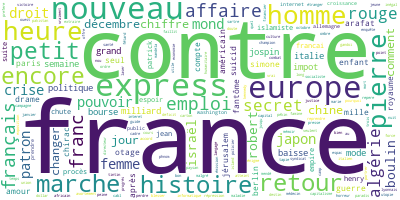

In [10]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list([' '.join(word_list_i) for word_list_i in title_tokens]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

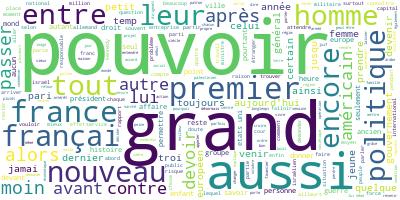

In [11]:
# Same for article bodies
# Join the different processed texts together.
long_string = ','.join(list([' '.join(word_list_i) for word_list_i in text_tokens]))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

__Perform LDA with Gensim__

Fixage arbitraire du nombre de topics, comme on fixerait arbitrairement k dans un k-means.

In [12]:
dic_title = corpora.Dictionary(title_tokens)
dic_text = corpora.Dictionary(text_tokens)
corpus_title = [dic_title.doc2bow(token) for token in title_tokens]
corpus_text = [dic_text.doc2bow(token) for token in text_tokens]

pickle.dump(corpus_title, open('corpus_title.pkl', 'wb'))
dic_title.save('dic_title.gensim')
pickle.dump(corpus_title, open('corpus_text.pkl', 'wb'))
dic_text.save('dic_text.gensim')

In [13]:
print([k for k in dic_title.values()])

['espac', 'tintin', 'boulin', 'robert', 'suicide', 'certitude', 'contre', 'pierre', 'mercredi', 'otage', 'soudain', 'planète', 'rouge', 'secret', 'ammar', 'forcer', 'marche', 'champion', 'discret', 'olympique', 'quinon', 'algérie', 'faillit', 'sanglant', 'israël', 'ébranlé', 'homme', 'objet', 'ponge', 'bess', 'georges', 'pourquoi', 'africain', 'long', 'mémoire', 'malgré', 'antigone', 'benazir', 'bhutto', 'janvier', 'pakistan', 'soupçon', 'triangle', 'campagne', 'ombre', 'darwin', 'tromper', 'dayan', 'symbole', 'impopulaire', 'leader', 'pérè', 'shimon', 'ainsi', 'exclusif', 'finir', 'phnom', 'témoignage', 'expliqu', 'simone', 'bureau', 'informatique', 'livré', 'jérusalem', 'nouveau', 'seul', 'chopinet', 'express', 'retrouve', 'touvier', 'tutelle', 'agent', 'faux', 'france', 'star', 'vrai', 'complexe', 'pinochet', 'challenger', 'drame', 'beineix', 'coluche', 'nourricier', 'marchandage', 'terrorisme', 'enquête', 'reprendre', 'espagne', 'goytisolo', 'sarrasin', 'attentat', 'blanco', 'carre

In [14]:
# get the topics! 

NUM_TOPICS = 10

for (corpus, dictionary) in [(corpus_title, dic_title), (corpus_text, dic_text)]:
    print('\nTopics')
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    ldamodel.save('model5.gensim')
    topics = ldamodel.print_topics(num_words=4)
    for topic in topics:
        print(topic)


Topics
(0, '0.010*"france" + 0.007*"baisse" + 0.007*"grand" + 0.007*"jospin"')
(1, '0.010*"emploi" + 0.010*"histoire" + 0.010*"suite" + 0.007*"patron"')
(2, '0.016*"crise" + 0.013*"encore" + 0.013*"contre" + 0.010*"italie"')
(3, '0.011*"jour" + 0.007*"israël" + 0.007*"comment" + 0.007*"henry"')
(4, '0.018*"europe" + 0.009*"marche" + 0.006*"algérie" + 0.006*"homme"')
(5, '0.022*"contre" + 0.010*"pierre" + 0.010*"france" + 0.010*"américain"')
(6, '0.011*"heure" + 0.008*"franc" + 0.008*"mond" + 0.008*"france"')
(7, '0.018*"nouveau" + 0.012*"france" + 0.009*"compte" + 0.009*"droit"')
(8, '0.013*"express" + 0.010*"français" + 0.007*"rouge" + 0.007*"guerre"')
(9, '0.020*"retour" + 0.010*"affaire" + 0.010*"express" + 0.010*"japon"')

Topics
(0, '0.005*"france" + 0.005*"politique" + 0.004*"pouvoir" + 0.004*"homme"')
(1, '0.005*"français" + 0.005*"pouvoir" + 0.004*"france" + 0.004*"politique"')
(2, '0.005*"homme" + 0.004*"franc" + 0.004*"pouvoir" + 0.003*"nouveau"')
(3, '0.004*"grand" + 0.003*

In [15]:
# to be continued
# https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21

__Analysis__

* at first sight, key words associated to the same topic do not always have much in common 
* some of the words used to define topics do not seem like relevant, high level key words
* maybe the corpus is to small or to heterogeneous to obtain relevant topics this way!

--> *Improvement ideas*
- preprocessing: remove figures ('000', '10', '100', '11', '12', '15', '16', '17', '1990', '1997', '20', '30', '31', '50', '500', '60')
- try clustering methods and put a word on the topics
- improve dictionary
- improve this first LDA model (more ideas [here](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/))
- get more data on specific topics


# 2. Clustering 

K-Means clustering and DBSCAN with tf-idf representation



### a. Build a tf-idf matrix to represent the corpus

__Naive approach based on word count__

We rapidly see that the use of lemmas is nessecary to avoid the explosion of our vocabulary. For example, "missives" and "missive" should be considered to be the same. 

In [16]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
word_count_vector=cv.fit_transform(news_df.text)

print(word_count_vector.shape)
# Houston, we have a dimensionality problem

(726, 43869)


In [17]:
# tf-idf with all the words
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

# print idf values 
idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
idf.sort_values(by=['idf_weights'])

,idf_weights
de,1.000000
la,1.022254
le,1.036419
des,1.047896
les,1.052235
...,...
missives,6.895779
missive,6.895779
compensés,6.895779
miradors,6.895779


We have to select the words with highest tf-idf count.

Improvement ideas:
    
* get rid of figures "000", "cinq"
* get rid of non topic words (destructive approach)
* custom build vocabulary for the corpus, based on previous NER extraction 
* use lemmas (root words) instead of full words (ex: français, france go back to the same entity)


__Tf-idf with lemmatized words__

We resuse the preprocessing made in the LDA section. We already obtain a smaller vocabulary, but it remains too big. So next step is to fit the Tf-Idf matrix with some constraints to reduce the number of features.

In [18]:
news_df['pre_title']=[' '.join(word_list_i) for word_list_i in title_tokens] # preprocessed titles
news_df['pre_text']=[' '.join(word_list_i) for word_list_i in text_tokens] # preprocessed article bodies

In [19]:
# Re-compute the word-count for preprocessed texts

word_count_vector=cv.fit_transform(news_df.pre_text)

print(word_count_vector.shape)

# tf-idf with all the words
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

# print idf values 
idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
idf.sort_values(by=['idf_weights'])

(726, 33630)


,idf_weights
pouvoir,1.602474
premier,1.610041
grand,1.617665
nouveau,1.675423
aussi,1.689029
...,...
houle,6.895779
houillon,6.895779
houill,6.895779
honved,6.895779


__Tf-Idf vectorizer with constraints__

In [20]:
# fit tf-idf on all texts with constraints on document frequency and number of tokens
tfidf_vectorizer=TfidfVectorizer(max_df = 700, max_features=500, smooth_idf=True,use_idf=True) 
X = tfidf_vectorizer.fit_transform(news_df.pre_text) # X is a matrix

In [21]:
# take a look at the result
print(tfidf_vectorizer.get_feature_names())
print(X.shape)

['abord', 'accepter', 'accord', 'action', 'activité', 'administration', 'affaire', 'africain', 'ailleurs', 'ainsi', 'algérie', 'algérien', 'allemagne', 'allemand', 'aller', 'alors', 'américain', 'amériqu', 'ancien', 'annoncer', 'année', 'appel', 'appeler', 'apprendre', 'après', 'arabe', 'argent', 'arme', 'armer', 'armée', 'arriver', 'arrêter', 'assez', 'association', 'assurer', 'atteindre', 'attendre', 'aucun', 'aujourd', 'aussi', 'autant', 'autorité', 'autour', 'autre', 'avant', 'avenir', 'avocat', 'avril', 'beaucoup', 'begin', 'bernard', 'besoin', 'blanc', 'bon', 'cadre', 'campagne', 'capital', 'cause', 'celui', 'centaine', 'central', 'centre', 'certain', 'certains', 'chacun', 'chambre', 'chance', 'changer', 'chaque', 'charger', 'chercher', 'chiffre', 'chine', 'chinois', 'chirac', 'choisir', 'choix', 'chose', 'chômage', 'civil', 'clair', 'commencer', 'comment', 'commission', 'commun', 'communauté', 'communiste', 'comprendre', 'compris', 'compte', 'condition', 'conduire', 'connaître',

__Tf-idf with entity-based vocabulary__

In [22]:
PER_df=pd.read_csv('articles_PER.csv')
LOC_df=pd.read_csv('articles_LOC.csv')

In [23]:
PER_df.describe()

,Unnamed: 0,PER_count
count,287.000000,287.000000
mean,143.000000,5.487805
std,82.993976,4.539534
min,0.000000,3.000000
25%,71.500000,3.000000
50%,143.000000,4.000000
75%,214.500000,6.000000
max,286.000000,35.000000


In [24]:
PER_highest=PER_df[PER_df['PER_count']>5]
print(list(PER_highest.PER_entity))
PER_highest.head()

['françois mitterrand', 'jacques chirac', 'ii', 'de gaulle', 'président de la république', 'lionel jospin', 'général de gaulle', 'chirac', 'yasser arafat', 'mitterrand', 'menahem begin', 'bill clinton', 'charles pasqua', 'moshe dayan', 'arafat', 'hier', 'staline', 'alain juppé', 'edouard balladur', '-major', 'washington', 'begin', '-aviv', '-ci', 'itzhak rabin', 'sadate', 'lénine', 'golda meir', 'fini', 'helmut kohl', 'pierre bérégovoy', 'martine aubry', 'kennedy', 'hitler', "valéry giscard d'estaing", 'nasser', 'rabin', 'raymond barre', 'expert', 'shimon peres', 'napoléon', 'eisenhower', 'hasard', 'giscard', 'george bush', 'mao', 'saddam hussein', 'boulin', 'delmas', 'david ben gourion', 'robert badinter', 'georges pompidou', 'anouar el-sadate', 'voulez', 'jean-paul ii', 'christ', 'jimmy carter', 'michel rocard', 'voltaire', 'pierre mendès france', 'pierre mauroy', 'robert', 'regardez', 'marx', 'françoise giroud', 'soudain', 'mendès france', 'pompidou', 'louis xiv', 'mikhaïl gorbatche

,Unnamed: 0,PER_entity,PER_count
0,0,françois mitterrand,35
1,1,jacques chirac,31
2,2,ii,29
3,3,de gaulle,26
4,4,président de la république,26


In [25]:
LOC_df.describe()

,Unnamed: 0,LOC_count
count,439.00000,439.000000
mean,219.00000,9.621868
std,126.87264,17.268576
min,0.00000,3.000000
25%,109.50000,3.000000
50%,219.00000,5.000000
75%,328.50000,8.500000
max,438.00000,158.000000


In [26]:
LOC_highest=LOC_df[LOC_df['LOC_count']>6]
print(list(LOC_highest.LOC_entity))
LOC_highest.head()

['paris', 'france', 'la france', 'etat', 'etats-unis', 'europe', '-', "l'europe", 'allemagne', 'américains', 'état', 'de france', 'israël', 'londres', 'jérusalem', 'français', 'grande-bretagne', 'moscou', 'terre', 'washington', 'chine', 'afrique', '»', 'la chine', 'amérique', 'new york', 'algérie', 'allemands', 'angleterre', 'occident', 'berlin', 'italie', 'japon', 'beyrouth', 'espagne', 'genève', 'russie', 'suisse', 'pékin', "l'amérique", 'bruxelles', 'soleil', "l'italie", 'f', 'gaza', 'liban', 'cisjordanie', 'syrie', 'la terre', 'jordanie', 'iran', 'sinaï', 'asie', 'mercredi', 'damas', 'cher', 'lyon', 'européens', 'lune', "l'afrique", 'russes', 'pologne', 'egypte', 'algériens', 'israéliens', 'rome', 'c?ur', 'anglais', 'alger', 'inde', 'cuba', 'arabie saoudite', 'matignon', 'marseille', 'irak', 'vienne', "l'empire", 'madrid', 'pacifique', 'hongrie', 'suède', 'bordeaux', "l'algérie", 'tunisie', 'strasbourg', 'atlantique', 'britanniques', 'soudan', "quai d'orsay", 'mexique', 'belgique',

,Unnamed: 0,LOC_entity,LOC_count
0,0,paris,158
1,1,france,156
2,2,la france,144
3,3,etat,124
4,4,etats-unis,116


In [27]:
vocabulary=['paris', 'france', 'etat', 'etats-unis', 'europe', 'allemagne', 'américains', 'état', 'de france', 'israël', 'londres', 'jérusalem', 'français', 'grande-bretagne', 'moscou', 'terre', 'washington', 'chine', 'afrique', '»', 'la chine', 'amérique', 'new york', 'algérie', 'allemands', 'angleterre', 'occident', 'berlin', 'italie', 'japon', 'beyrouth', 'espagne', 'genève', 'russie', 'suisse', 'pékin', "l'amérique", 'bruxelles', 'soleil', "l'italie", 'f', 'gaza', 'liban', 'cisjordanie', 'syrie', 'la terre', 'jordanie', 'iran', 'sinaï', 'asie', 'mercredi', 'damas', 'cher', 'lyon', 'européens', 'lune', "l'afrique", 'russes', 'pologne', 'egypte', 'algériens', 'israéliens', 'rome', 'c?ur', 'anglais', 'alger', 'inde', 'cuba', 'arabie saoudite', 'matignon', 'marseille', 'irak', 'vienne', "l'empire", 'madrid', 'pacifique', 'hongrie', 'suède', 'bordeaux', "l'algérie", 'tunisie', 'strasbourg', 'atlantique', 'britanniques', 'soudan', "quai d'orsay", 'mexique', 'belgique', 'sienne', 'maroc', 'chinois', 'japonais', 'italiens', 'téhéran', 'los angeles', "l'asie", 'champagne', 'syriens', 'turquie', 'munich', 'egyptiens', 'afrique du sud', 'libye', 'avais', 'danemark', 'américain', 'hexagone', 'portugal', 'au caire', 'koweït', 'méditerranée', 'le soleil', 'canal de suez', 'vatican', 'vichy', 'kremlin', "l'espagne", 'caire', 'roumanie', 'tchécoslovaquie', 'norvège', 'tokyo', 'le japon', 'autriche', 'canada', 'versailles', "côte-d'ivoire", 'kenya', 'maghreb', 'pakistan', 'laos', 'sénégal', 'francfort', 'vietnam', 'loire', 'toulouse', 'californie', 'prague', 'grèce', 'nigeria', 'gatt', 'du japon', 'madagascar', 'corée', 'congo', 'gabon', 'croyez', 'australie', 'voudrais', 'cambodge', 'luxembourg']